# 1. Data Preparation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

# Get the ranking Data 
rankings = pd.read_csv("https://raw.githubusercontent.com/eozhisarcikli/football-world-cup-winner-prediction/main/data/fifa_ranking.csv", encoding = 'ISO-8859-1')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
# Get weighted points by summing cur_year_avg_weighted + two_year_ago_weighted + three_year_ago_weighted
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format


# Get the match Data 
matches = pd.read_csv("https://raw.githubusercontent.com/eozhisarcikli/football-world-cup-winner-prediction/main/data/results.csv", encoding = 'ISO-8859-1')
# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/eozhisarcikli/football-world-cup-winner-prediction/main/data/WorldCup2018Dataset.csv", encoding = 'ISO-8859-1')

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match against', 'Second match against', 'Third match against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# set index to team 
world_cup = world_cup.set_index('Team')

In [2]:
rankings.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0


In [3]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
world_cup.head()

,Group,First match against,Second match against,Third match against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia
Portugal,B,Spain,Morocco,Iran


# 2. Feature Selection & Generation

In [5]:
# we want to have the ranks for every day 
# We use resample to sample by Day and get the first date
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
  
rankings.head()

,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,2003-01-15,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
1,2003-01-16,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
2,2003-01-17,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
3,2003-01-18,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
4,2003-01-19,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0


In [6]:
# join the ranks for the Home team
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0


In [7]:
# join the ranks for the Away teams
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0


In [8]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0,37.0,40.5,0.0,2,True,True
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0,-6.0,11.0,0.0,0,False,False
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0,-59.0,64.5,0.0,5,True,True
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0,-21.0,75.5,0.0,1,True,False
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0,62.0,36.0,0.0,-2,False,True


# 3. Modelling with Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       False       0.69      0.68      0.69      1908
        True       0.67      0.68      0.67      1788

    accuracy                           0.68      3696
   macro avg       0.68      0.68      0.68      3696
weighted avg       0.68      0.68      0.68      3696



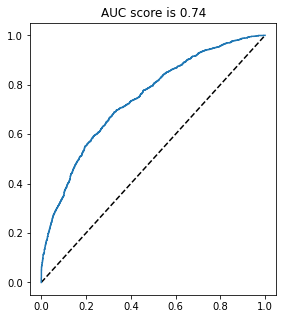

In [10]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report

# We look at only 4 features
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Use a logistic Regression model
logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Plot our model results 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable.

Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

Stakes distribution in the wrong predictions
True     0.575169
False    0.424831
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


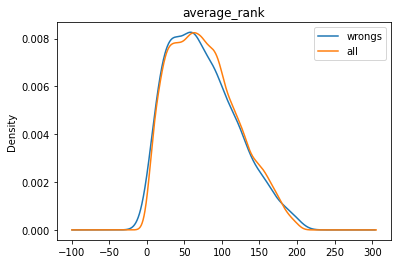

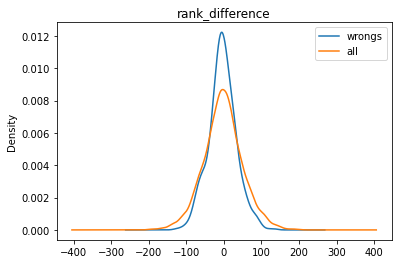

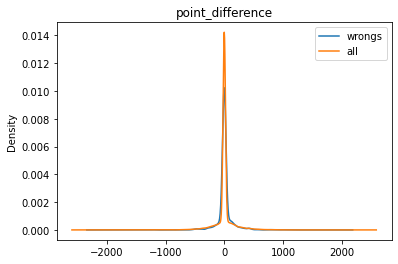

In [11]:
features = ['average_rank', 'rank_difference', 'point_difference']

# Get the wrongly predicted matches
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read

*   we predict worse for closer ranks
*   lower ranks in general
*   and somewhat for matches with no stakes (Friendly here) - fortunately, this implies that for the world cup our predicitons may be somewhat even better

# 4. Simulation

In [12]:
# let's define a small margin that we add, so that we predict draws when probabilies lie between 0.475 and 0.525
margin = 0.025

# let's define the rankings at the time of the World Cup (so we sort on most recent rankings)
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_rankings.head()

,rank_date,rank,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
country_full,,,,,,,
Argentina,2018-06-07,5.0,ARG,404.07,248.99,183.59,836.65
Australia,2018-06-07,36.0,AUS,366.60,98.16,59.79,524.55
Belgium,2018-06-07,3.0,BEL,629.98,158.94,186.58,975.50
Brazil,2018-06-07,2.0,BRA,558.95,168.06,162.38,889.39
Colombia,2018-06-07,16.0,COL,292.09,199.73,166.38,658.20


In [14]:
from itertools import combinations

opponents = ['First match against', 'Second match against', 'Third match against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        # get the prediction proability of the home team winning
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group H:___
Poland vs. Senegal: Poland wins with 0.59
Poland vs. Colombia: Poland wins with 0.54
Poland vs. Japan: Poland wins with 0.70
Senegal vs. Colombia: Colombia wins with 0.58
Senegal vs. Japan: Senegal wins with 0.63
Colombia vs. Japan: Colombia wins with 0.67
___Starting group E:___
Brazil vs. Switzerland: Brazil wins with 0.54
Brazil vs. Costa Rica: Brazil wins with 0.62
Brazil vs. Serbia: Brazil wins with 0.65
Switzerland vs. Costa Rica: Switzerland wins with 0.59
Switzerland vs. Serbia: Switzerland wins with 0.63
Costa Rica vs. Serbia: Costa Rica wins with 0.54
___Starting group F:___
Germany vs. Mexico: Germany wins with 0.61
Germany vs. Sweden: Germany wins with 0.63
Germany vs. Korea Republic: Germany wins with 0.65
Mexico vs. Sweden: Mexico wins with 0.54
Mexico vs. Korea Republic: Mexico wins with 0.65
Sweden vs. Korea Republic: Sweden wins with 0.62
___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.55
Russia vs. Egypt: Egypt wins wi

In [15]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.323245
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.538740
Spain,B,Portugal,Iran,Morocco,6,1.714135
Portugal,B,Spain,Morocco,Iran,9,1.854178
Denmark,C,Peru,Australia,France,7,1.766835
France,C,Australia,Peru,Denmark,5,1.632908
Croatia,D,Nigeria,Argentina,Iceland,4,1.541201
Argentina,D,Iceland,Croatia,Nigeria,9,1.859186
Brazil,E,Switzerland,Costa Rica,Serbia,9,1.806766


In [16]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        # Get the winner
        home_win_prob = model.predict_proba(row)[:,1][0]
        
        # Display resultes
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.53
Denmark vs. Croatia: Denmark wins with probability 0.56
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.60
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.65
England vs. Poland: Poland wins with probability 0.52


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.52
Brazil vs. Belgium: Belgium wins with probability 0.52
Portugal vs. Argentina: Portugal wins with probability 0.52
Germany vs. Poland: Germany wins with probability 0.59


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.56
Portugal vs. Germany: Germany wins with probability 0.59


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.57




# 5. Visualization

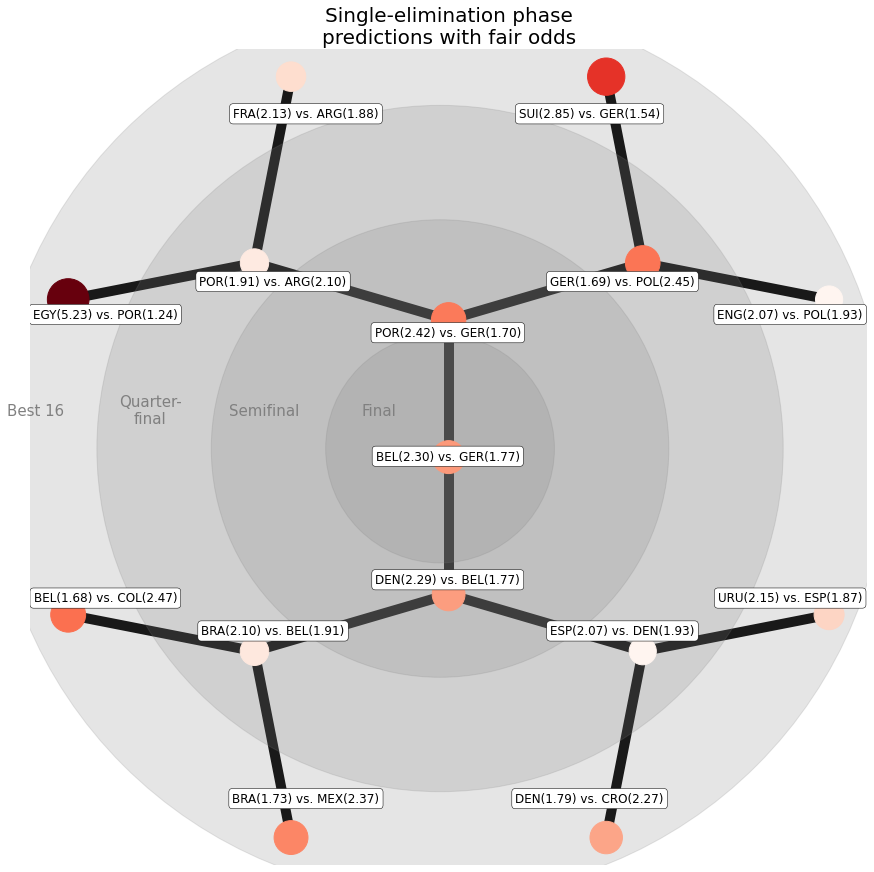

In [23]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(15, 15))
ax = plt.subplot(1,1,1)

# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=15, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()
